In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.spatial.distance import pdist, cosine
from scipy import stats
from itertools import combinations, permutations
%matplotlib inline

age_classes = ((0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 100))


birth_classes = ((2000, 2018),
                 (1974, 1999),
                 (1969, 1974),
                 (1957, 1968),
                 (1918, 1956))

def age_to_age_class(age, age_classes):
    for lb, ub in age_classes:
        if age >= lb and age <=ub:
            if lb != 65:
                ac = '-'.join((str(lb), str(ub)))
            else:
                ac = '65+'
            break
    return ac

ags = [age_to_age_class(a0, age_classes) for a0, a1 in age_classes]
seasons = [str(s) for s in range(2008, 2019)] + ['2009Pan']
np.random.seed(100)

rcParams['font.sans-serif'] = 'arial'


# Stratified raw data

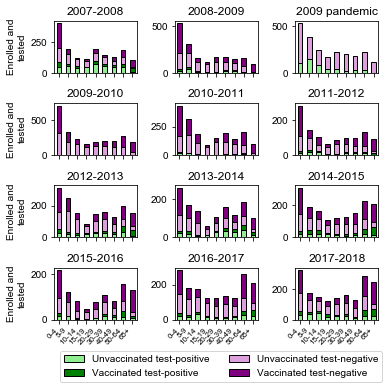

In [2]:
finaldf = pd.read_csv('../raw_data/Test_status_by_season_age_and_vax.csv')
i=1

for season, seasondf in finaldf.groupby('Season'):
    plt.subplot(4,3,i )
    
    t = seasondf.copy()
    t.index = t['Age group']
    t = t.loc[ags, ]
    t.plot.bar(stacked=True,
                      color = ['lightgreen', 'green', 'plum', 'purple'],
                      edgecolor='black', ax=plt.gca(), legend=False)
    plt.ylabel('Enrolled and\ntested')
    plt.xlabel('')
    

    plt.xticks(range(0, len(t)), t['Age group'], rotation=45, ha='right', size=8)
    

    if i not in [10, 11, 12]:
        plt.xticks(range(0, len(t)), [])
    if i not in [1,4,7,10]:
        plt.ylabel('')

    if season != '2009Pan':
        title = '%s-%s'%(int(season) - 1, season)
    else:
        title = '2009 pandemic'
    plt.title(label=title)
    i += 1
    
    
plt.gcf().set_size_inches(5.5,5)
plt.gcf().align_ylabels()
plt.tight_layout()

plt.legend(loc='center', bbox_to_anchor=(-0.9, -0.9), ncol=2)

# Demography

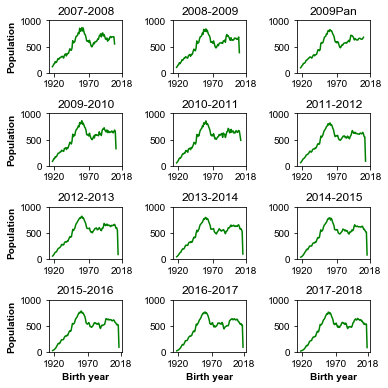

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import splev, splrep
import numpy as np
from matplotlib import rcParams, colors
import seaborn as sns
%matplotlib inline

rcParams['font.sans-serif'] = 'arial'

demodf = pd.read_csv('../data/demography_by_birth_year.csv')

subplot = 1
for season, df in demodf.groupby('Season'):

    if season >= 2008:
        plt.subplot(4,3,subplot)
        
        plotdf = df.sort_values('Birth_year').copy()
        plt.plot(plotdf['Birth_year'], plotdf['Population'], '-', color='green')
        plt.xticks([1920, 1970, 2018])
        plt.ylim(0, 1000)
        
        
        if season != 2009.5:
            plt.title(str(int(season) - 1) + '-' + str(int(season)))
        else:
            plt.title('2009Pan')
            
        if subplot in [10, 11, 12]:
            plt.xlabel('Birth year', weight='bold')
        else:
            plt.xlabel('')
        if subplot in [1, 4, 7, 10]:
            plt.ylabel('Population', weight='bold')
        else:
            plt.ylabel('')
        subplot += 1
plt.gcf().set_size_inches(5.5, 5.5)
plt.tight_layout()

# Vaccination coverage

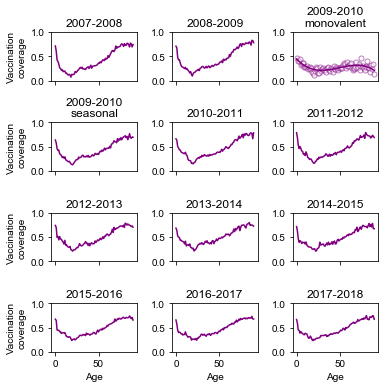

In [4]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.spatial.distance import pdist, cosine
from scipy import stats
from itertools import combinations, permutations
from scipy.interpolate import splev, splrep
%matplotlib inline

np.random.seed(100)

rcParams['font.sans-serif'] = 'arial'

vac_by_age = pd.read_csv('../raw_data/vac_coverage_by_age_seasonal_2010.csv')
raw_mono = vac_counts = pd.read_csv('../raw_data/monovalent_vaccination_counts.csv')
demo_data = pd.read_csv('../data/demography_by_age_extended.csv')

def age_to_age_class(age):
    for l, u in age_classes:
        if age <= u and age >= l:
            age_class = '-'.join([str(l), str(u)])
            break
    if age_class == '65-200':
        age_class = '65-100'
    return age_class


age_classes = [(0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 200)]

spl = splrep(vac_counts.age, vac_counts.Coverage, s=5)
interp = splev(range(0, max(vac_counts.age) + 1), spl)
mono_cov = demo_data[(demo_data.Season == 2009.5) &
                      (demo_data.Age <= max(vac_counts.age))].copy()
mono_cov['Vaccinated'] = mono_cov.Population * interp
mono_cov['Unvaccinated'] = mono_cov.Population - mono_cov.Vaccinated
mono_cov['coverage'] = interp
mono_cov['Season'] = '2010'
mono_cov = mono_cov[['Age', 'Season', 'coverage', 'Vaccinated', 'Unvaccinated']]


subplot = 1
for season, seasondf in vac_by_age.groupby('Season'):
    if season == 2010:
        title = '2009-2010\nseasonal'
        subplot += 1
    else:
        title = str(season-1) +'-' + str(season)
    plt.subplot(4, 3, subplot)
    ax = plt.gca()
    seasondf.plot(x='Age', y='coverage', ax=ax, legend=False, color='purple')
    
    ticks, labels = plt.xticks()
    xmin, xmax = plt.xlim()
    if subplot in [1, 4, 7, 10]:
        plt.ylabel('Vaccination\ncoverage')
    if subplot not in [10, 11, 12]:
        plt.xlabel('')
        plt.xticks([0, 50, 100], [])
    else:
        plt.xticks([0, 50, 100], [0, 50, 100])
    plt.xlim(xmin, xmax)
    plt.title(title)
    plt.ylim(0, 1)
    subplot += 1

plt.subplot(4,3,3)
plt.plot(raw_mono.age, raw_mono.Coverage, 'o', alpha=0.5,color='white', markeredgecolor='purple',markersize=5)
mono_cov.plot(x='Age', y='coverage', ax=plt.gca(), color='purple', legend=False)

plt.xlabel('')
ticks, labels = plt.xticks()
xmin, xmax = plt.xlim()
plt.xticks(ticks, [])
plt.xlim(xmin, xmax)
plt.ylim(0, 1)
plt.title('2009-2010\nmonovalent')
plt.gcf().set_size_inches(5.5, 5.5)

plt.tight_layout()

# High-risk medical conditions

C:\Users\parevalo\Miniconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


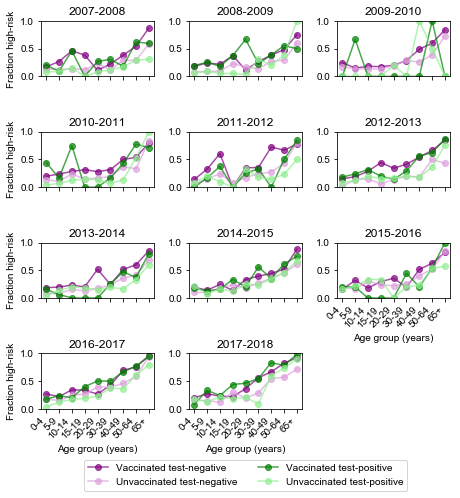

In [5]:
import pandas as pd
from dateutil import relativedelta
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import pymmwr
import random
%matplotlib inline

rcParams['font.sans-serif'] = 'arial'

age_classes = [(0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 200)]

def dominant_subtype(year):
    if year in ['2009', '2009Pan', '2010', '2014', '2016']:
        subtypes = ['H1N1', 'H1N1pdm']
    else:
        subtypes = ['H3N2']
    return subtypes

def age_to_age_class(age):
    for l, u in age_classes:
        if age <= u and age >= l:
            age_class = '-'.join([str(l), str(u)])
            break
    if age_class == '65-200':
        age_class = '65+'
    return age_class

def season_to_season_float(season_str):
    if season_str == '2009Pan':
        s = 2009.5
    else:
        s = float(season_str)
    return s

def season_float_to_season(season_float):
    if season_float == 2009.5:
        s = '2009Pan'
    else:
        s = str(int(season_float))
    return s

def event_date_to_season_week(date):
    event = datetime.strptime(date, '%Y-%m-%d').date()
    mmwr_date = pymmwr.date_to_epiweek(event)
    epiweek = pymmwr.Epiweek(mmwr_date.year, mmwr_date.week)
    return pymmwr.epiweek_to_date(epiweek)

def tick_to_date(tick):
    year = int(np.floor(tick))
    week = int((tick - np.floor(tick)) * 54)
    epiweek = pymmwr.Epiweek(year, week)
    return pymmwr.epiweek_to_date(epiweek)

def season_section(season, week):
    m = median_weeks[season]
    if week < m:
        s = 'Start'
    elif week > m:
        s = 'End'
    elif week == m:
        s = 'Median'
    return s

def is_vaccinated(e, v):
    if v != None and v != 'None' and v != 'Unknown' and type(v) == str:
        e_date = datetime.strptime(e, '%Y-%m-%d')
        v_date  = datetime.strptime(v, '%Y-%m-%d')
        d = relativedelta(v_date, e_date)
        if d.months < 0 or d.days < -14:
            vax = 1
        else:
            vax = 0
    else:
        vax = 0
    return vax

plotdf = pd.read_csv('../raw_data/comorbidities_by_age_group_tn.csv')
tnd = pd.read_csv('../data/test_negative_data_by_age_group.csv')
coverage = pd.read_csv('../raw_data/vac_coverage_by_age_seasonal_2010.csv')
coverage['age_group'] = [age_to_age_class(a) for a in coverage.Age]
coverage = coverage.groupby(['Season', 'age_group']).sum()[['Vaccinated', 'Unvaccinated']]
coverage['coverage'] = coverage.Vaccinated / (coverage.Vaccinated + coverage.Unvaccinated)

temp = pd.read_csv('../raw_data/comorbidities_by_age_group_tn.csv', index_col = [0,1])
all_comorb = pd.read_csv('../raw_data/comorbidities_by_age_group.csv', index_col=[0,1])
all_comorb = all_comorb - temp
all_comorb = all_comorb.reset_index()

# plot fraction with high-risk medical condition

plotdf['vac_frac'] = plotdf['Vaccinated HR'] / plotdf['Vaccinated']
plotdf['unvac_frac'] = plotdf['Unvaccinated HR'] / plotdf['Unvaccinated']

all_comorb['vac_frac'] = all_comorb['Vaccinated HR'] / all_comorb['Vaccinated']
all_comorb['unvac_frac'] = all_comorb['Unvaccinated HR'] / all_comorb['Unvaccinated']

subplot = 1
for s, sdf in plotdf.groupby('Season'):
    plt.subplot(4,3,subplot)
    cases = all_comorb[all_comorb.Season == s]
    if s != '2009Pan':
        p = sdf.copy()
        p.index = p['Age group']
        p = p.loc[[age_to_age_class(a1) for a1, a2 in age_classes], ]
        p.plot(y='vac_frac', ax = plt.gca(), legend=False, color='purple', marker='o', alpha=0.7)
        p.plot(y='unvac_frac', ax = plt.gca(), legend=False, color='plum', marker='o', alpha=0.7)
        
        p = cases.copy()
        p.index = p['Age group']
        p = p.loc[[age_to_age_class(a1) for a1, a2 in age_classes], ]
        p = p.fillna(0)
        p.plot(y='vac_frac', ax = plt.gca(), legend=False, color='green', marker='o', alpha=0.7)
        p.plot(y='unvac_frac', ax = plt.gca(), legend=False, color='lightgreen', marker = 'o', alpha=0.7)

        
        
        
        if subplot in [9, 10, 11]:
            plt.xticks(range(0, len(age_classes)), [age_to_age_class(a1) for a1, a2 in age_classes], rotation = 45, ha='right')
            plt.xlabel('Age group (years)')
        else:
            plt.xticks(range(0, len(age_classes)), [])
            plt.xlabel('')
            
        if subplot in [1,4,7,10]:
            plt.ylabel('Fraction high-risk')
        
        plt.ylim(0, 1)
        plt.title('%s-%s'%(int(s) - 1, s))
        subplot += 1
        
plt.gcf().set_size_inches(6.5, 6.5)
plt.tight_layout()
plt.legend(loc = 'center', bbox_to_anchor=(0.5, -1.2), ncol=2, labels=['Vaccinated test-negative', 'Unvaccinated test-negative', 'Vaccinated test-positive', 'Unvaccinated test-positive'])

# Test-negative vaccination

C:\Users\parevalo\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



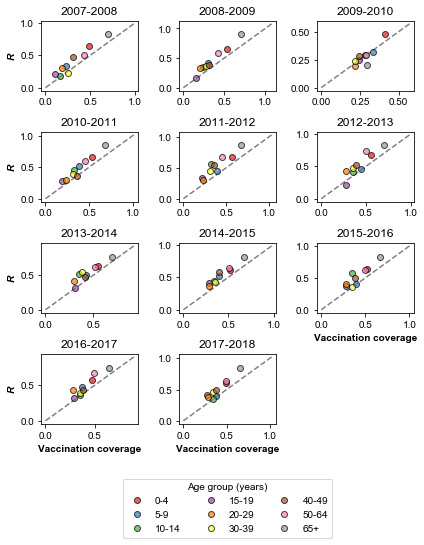

In [6]:
def age_to_age_class(age):
    for l, u in age_classes:
        if age <= u and age >= l:
            age_class = '-'.join([str(l), str(u)])
            break
    if age_class == '65-200':
        age_class = '65-100'
    return age_class


vac_counts = pd.read_csv('../raw_data/monovalent_vaccination_counts.csv')
demo_data = pd.read_csv('../data/demography_by_age_extended.csv')
df_c = pd.read_csv('../raw_data/vac_coverage_by_age_seasonal_2010.csv')
tn_data = pd.read_csv('../raw_data/test-negative_vac_status.csv')

age_classes = [(0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 200)]

spl = splrep(vac_counts.age, vac_counts.Coverage, s=5)
interp = splev(range(0, max(vac_counts.age) + 1), spl)
mono_cov = demo_data[(demo_data.Season == 2009.5) &
                      (demo_data.Age <= max(vac_counts.age))].copy()
mono_cov['Vaccinated'] = mono_cov.Population * interp
mono_cov['Unvaccinated'] = mono_cov.Population - mono_cov.Vaccinated
mono_cov['coverage'] = interp
mono_cov['Season'] = '2010'
mono_cov = mono_cov[['Age', 'Season', 'coverage', 'Vaccinated', 'Unvaccinated']]


df_c = df_c[df_c.Season != 2010]
df_c = pd.concat([df_c, mono_cov])
df_c['age_group'] = df_c.Age.apply(age_to_age_class)
df_c = df_c.groupby(['Season', 'age_group']).sum().reset_index()
df_c['coverage'] = df_c.Vaccinated / (df_c.Vaccinated + df_c.Unvaccinated)
df_c = df_c[['Season', 'age_group', 'coverage']]
df_c['Season'] = df_c.Season.astype(float)



combined = tn_data.merge(df_c, on=['Season', 'age_group'])


pal = sns.color_palette('Set1', 9).as_hex()
subplot = 1
for season, seasondf in combined.groupby('Season'):
    plt.subplot(4, 3, subplot)
    plotdf = seasondf.copy()
    plotdf.index = plotdf.age_group
    plotdf = plotdf.loc[[age_to_age_class(l) for l,u in age_classes], ]
    maxc = plotdf.max().coverage
    maxv = plotdf.max().V_factor

    
    max_coord = 1.2 * maxv
    
    i = 0
    plt.plot([0, max_coord], [0, max_coord], '--', color='grey')
    for age_group, row in plotdf.iterrows():
        if age_group == '65-100':
            label = '65+'
        else:
            label = age_group
        plt.plot([row.coverage],
                 [row.V_factor],
                 'o', color= pal[i],
                 label=label,
                 markeredgecolor='k',
                 markersize=6,
                 alpha=0.7)
        i+=1
    

    plt.title(str(season - 1) + '-' + str(season))
    
    if subplot in [1,4,7,10]:
        plt.ylabel('R', weight='bold', style='italic')
    if subplot in [9, 10, 11]:
        plt.xlabel('Vaccination coverage', weight='bold')
    subplot += 1
plt.gcf().set_size_inches(6, 6.5)
plt.tight_layout()
plt.legend(ncol=3, title='Age group (years)', loc='center', bbox_to_anchor=(0.5, -1.2))


# Repeat vaccination

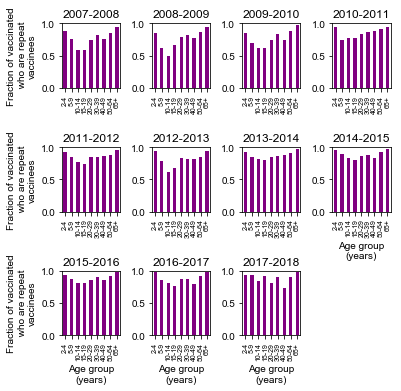

In [7]:
plotdf = pd.read_csv('../raw_data/repeat_vaccination.csv')

subplot = 1
new_labels = ['2-4',
              '5-9',
              '10-14',
              '15-19',
              '20-29',
              '30-39',
              '40-49',
              '50-64',
              '65+']

for season, seasondf in plotdf.groupby('Season'):
    if season != '2009Pan':
        plt.subplot(3, 4, subplot)
        ax = plt.gca()
        seasondf.plot.bar(x='Age group', y='Fraction repeat vaccinees', ax=ax, color='purple', legend=False)
        plt.ylim(0, 1)
        plt.title(str(int(season) - 1) + '-' + str(season))
        if subplot >= 8:
            ticks, labels = plt.xticks()
            plt.xticks(ticks, new_labels, size=7)
            plt.xlabel('Age group\n(years)')
        else:
            ticks, labels = plt.xticks()
            plt.xticks(ticks, new_labels, size=7)
            plt.xlabel('')
            
        if subplot in (1,5,9):
            plt.ylabel('Fraction of vaccinated\n who are repeat\nvaccinees')
        subplot += 1  
plt.gcf().set_size_inches(5.75, 5.5)
plt.tight_layout(w_pad = 0.2)

# Vacine type

Text(-0.1, 1.1, 'B')

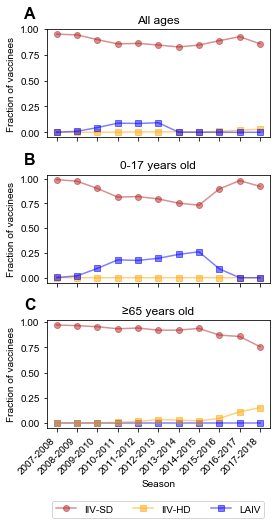

In [8]:

df = pd.read_csv('../raw_data/vaccine_type.csv')
a=0.5
plt.subplot(3,1,1)
temp = df[(df.age_group == 'all_ages') & (df.vaccine_type == 'hd')]
x = temp.Season
y = temp['Fraction of vaccinees']
y1 = df[(df.age_group == 'all_ages') & (df.vaccine_type == 'laiv')]['Fraction of vaccinees']
y0 = df[(df.age_group == 'all_ages') & (df.vaccine_type == 'sd')]['Fraction of vaccinees']
plt.plot(x, y, '-s', color='orange', label='IIV-HD', alpha=a)
plt.plot(x, y1,'-s', color='blue', label='LAIV', alpha=a)
plt.plot(x, y0,'-o', color='firebrick', label='IIV', alpha=a)
plt.xticks(range(2007, 2018), ['%s-%s'%(s, s+1) for s in range(2007, 2018)], rotation=45, ha='right')
plt.ylabel('Fraction of vaccinees')
plt.title('All ages')
plt.gca().text(-0.1, 1.1, 'A', transform=plt.gca().transAxes, 
            size=16, weight='bold')
plt.xticks(range(2007, 2018), [])



plt.subplot(3,1,3)
temp = df[(df.age_group == '65+') & (df.vaccine_type == 'hd')]
x = temp.Season
y = temp['Fraction of vaccinees']
y1 = df[(df.age_group == '65+') & (df.vaccine_type == 'laiv')]['Fraction of vaccinees']
y0 = df[(df.age_group == '65+') & (df.vaccine_type == 'sd')]['Fraction of vaccinees']
plt.plot(x, y1, '-s', color='blue', label='LAIV', alpha=a)
plt.plot(x, y, '-s', color='orange', label='IIV-HD', alpha=a)
plt.plot(x, y0,'-o', color='firebrick', label='IIV', alpha=a)
plt.xticks(range(2007, 2018), ['%s-%s'%(s, s+1) for s in range(2007, 2018)], rotation=45, ha='right')
plt.ylabel('Fraction of vaccinees')
plt.xlabel('Season')
plt.title('≥65 years old')
plt.gca().text(-0.1, 1.1, 'C', transform=plt.gca().transAxes, 
            size=16, weight='bold')


plt.subplot(3,1,2)

temp = df[(df.age_group == '0-17') & (df.vaccine_type == 'hd')]
x = temp.Season
y1 = temp['Fraction of vaccinees']
y = df[(df.age_group == '0-17') & (df.vaccine_type == 'laiv')]['Fraction of vaccinees']
y0 = df[(df.age_group == '0-17') & (df.vaccine_type == 'sd')]['Fraction of vaccinees']
plt.plot(x, y0,'-o', color='firebrick', label='IIV-SD', alpha=a)
plt.plot(x, y1, '-s', color='orange', label='IIV-HD', alpha=a)
plt.plot(x, y, '-s', color='blue', label='LAIV', alpha=a)

xmin,xmax = plt.xlim()
plt.xticks(range(2007, 2018), [])
plt.ylabel('Fraction of vaccinees')
plt.title('0-17 years old')


plt.gcf().set_size_inches(4,7)
plt.tight_layout()
plt.legend(loc='center', bbox_to_anchor=(0.5,-2.1), ncol=3)
plt.gca().text(-0.1, 1.1, 'B', transform=plt.gca().transAxes, 
            size=16, weight='bold')

